<a href="https://colab.research.google.com/github/OvinduWijethunge/Machine_Learning_Projects/blob/version-1/youtube%20spam%20classifier/GradientBoost%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('models.csv')
#url = 'https://raw.githubusercontent.com/OvinduWijethunge/Machine_Learning_Projects/master/youtube%20spam%20classifier/model.csv'
#df = pd.read_csv(url)
pd.set_option('display.max_columns',None)

In [3]:
df.head()

,Unnamed: 0,sim_content,sim_comment,word_count,duplicate_word_ratio,length_of_comment,stop_word_ratio,post_coment_gap,black_word_count,comment_duplication,is_spam,no_of_sentences_2,no_of_sentences_3,num_of_punctuations_1.0,num_of_punctuations_2.0,num_of_punctuations_3.0,num_of_punctuations_4.0,num_of_punctuations_5.0,num_of_punctuations_6.0,is_period_sequence_1,is_link_1,is_youtube_link_1,is_number_1
0,0,0.179708,0.239557,3.113118,0.0000,6.528592,0.000000,29.534492,0.222222,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.150545,0.184270,3.113118,0.0000,7.132631,0.111111,118.327895,0.000000,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,2,0.167696,0.191896,4.122173,0.0625,8.354362,0.062500,118.327895,0.125000,0.0,1,0,1,0,0,0,1,0,0,0,1,1,0
3,3,0.228679,0.217009,2.727171,0.0000,5.931295,0.142857,118.327895,0.142857,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.105110,0.125598,3.737346,0.0000,7.962790,0.000000,118.327895,0.076923,0.0,1,1,0,0,0,0,1,0,0,1,1,1,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sim_comment', 'word_count',
       'duplicate_word_ratio', 'length_of_comment', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'comment_duplication', 'is_spam',
       'no_of_sentences_2', 'no_of_sentences_3', 'num_of_punctuations_1.0',
       'num_of_punctuations_2.0', 'num_of_punctuations_3.0',
       'num_of_punctuations_4.0', 'num_of_punctuations_5.0',
       'num_of_punctuations_6.0', 'is_period_sequence_1', 'is_link_1',
       'is_youtube_link_1', 'is_number_1'],
      dtype='object')

#### Standardization  is no need for gb

In [5]:
dfc = df.copy()

In [6]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

In [7]:
X.columns

Index(['sim_content', 'sim_comment', 'word_count', 'duplicate_word_ratio',
       'length_of_comment', 'stop_word_ratio', 'post_coment_gap',
       'black_word_count', 'comment_duplication', 'no_of_sentences_2',
       'no_of_sentences_3', 'num_of_punctuations_1.0',
       'num_of_punctuations_2.0', 'num_of_punctuations_3.0',
       'num_of_punctuations_4.0', 'num_of_punctuations_5.0',
       'num_of_punctuations_6.0', 'is_period_sequence_1', 'is_link_1',
       'is_youtube_link_1', 'is_number_1'],
      dtype='object')

In [8]:
y

0       0
1       0
2       1
3       0
4       1
       ..
6962    0
6963    0
6964    0
6965    0
6966    0
Name: is_spam, Length: 6967, dtype: int64

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [9]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

X = X_ns
y = y_ns

The number of classes before fit Counter({0: 6255, 1: 712})
The number of classes after fit Counter({0: 6255, 1: 5629})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Hyperparameter Tuninng

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
gb = GradientBoostingClassifier()

In [13]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
grid={
    'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
    'n_estimators':[x for x in range(100,1000,2)],
    'max_depth':[2,3,4,5,6,7],
    'min_samples_split':[2,4,6,8,10,20,40,60,100], 
    'min_samples_leaf':[1,3,5,7,9],
    'max_features':[2,3,4,5,6,7],
    'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}

In [15]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=grid, n_jobs=-1,n_iter = 50, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [17]:
gb_random.fit(X_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=GradientBoostingClassifier(),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 3, 5, 7, 9],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              20, 40, 60, 100],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                               

#### Evaluvate

In [18]:
best_model = gb_random.best_estimator_

In [19]:
best_model

GradientBoostingClassifier(max_depth=6, max_features=6, min_samples_leaf=3,
                           n_estimators=894, subsample=0.95)

In [20]:
gb_random.best_params_

{'subsample': 0.95,
 'n_estimators': 894,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 6,
 'max_depth': 6,
 'learning_rate': 0.1}

In [21]:
gb_random.best_score_

0.9861745579931501

In [22]:
y_pred = best_model.predict(X_test)

In [23]:
err  =(y_pred- y_test)

<AxesSubplot:>

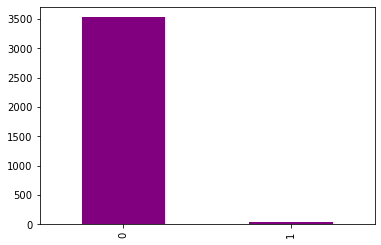

In [24]:
err.value_counts().plot(kind='bar',color='purple')

In [25]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.010095344924284913
MSE: 0.010095344924284913
RMSE: 0.10047559367470746


Text(0, 0.5, 'Feature Importance Score')

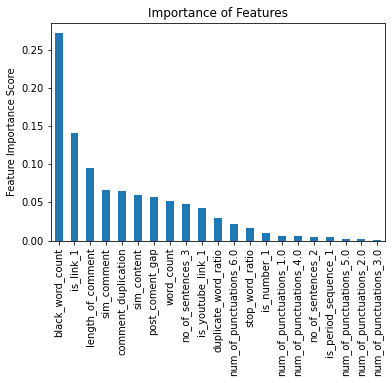

In [26]:
indices=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1863   36]
 [   0 1667]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1899
           1       0.98      1.00      0.99      1667

    accuracy                           0.99      3566
   macro avg       0.99      0.99      0.99      3566
weighted avg       0.99      0.99      0.99      3566



In [28]:
print("accuracy is {}".format(best_model.score(X_test, y_test)))

accuracy is 0.9899046550757151


In [29]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

## ROC curve

In [30]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [31]:
baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

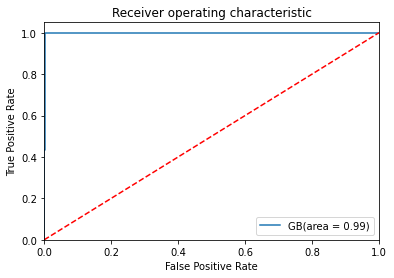

In [32]:
plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Recall - presicion with threshold values**

(0.0, 1.0)

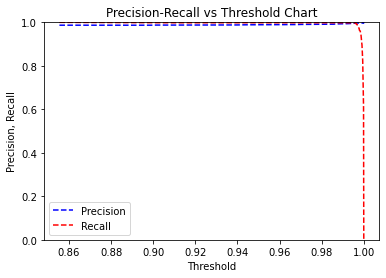

In [33]:
### Predict test_y values and probabilities based on random forest model
probs_y=best_model.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [34]:
import pickle
#open a file, where you ant to store the data
file = open('gboostv1.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()